In [1]:
from copy import deepcopy

import numpy as np
from tqdm import tqdm

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
matplotlib.rc('font', size=16)
plt.rcParams['figure.figsize'] = (12.0, 10.0)    # resize plots

# Setup

Set up a log likelihood function for each wimp mass. We could also have set up one likelihood function with many wimps, it doesn't make much difference.

(this approach is less memory-efficient as we have more pdfs in RAM, but a bit more efficient in CPU: having many WIMPs per model means you have to score each event for many sources)

In [272]:
from wimpy.xenon.base_model import config as base_config
from wimpy.xenon.base_model import nr_ignore_settings
from wimpy.likelihood import LogLikelihood
from scipy import stats

lfs = {}
wimp_masses = [10, 20, 50, 100, 1000]
# Sample low-mass wimps more, since most of their events are out of range
# Maybe we can cut off their spectra at 0.5 keV or something.
# 6 GeV would require something like a 250x multiplier... too impatient
sampling_multipliers = {10: 10, 20:2}   # Maybe 5x is overkill, but ok

for m in wimp_masses:    
    # Copy the base config and remove the wimps present there
    config = deepcopy(base_config)
    config['sources'] = [s for s in config['sources'] if not s['name'].startswith('wimp')]
    
    # Add this WIMP
    config['sources'].append({
        'energy_distribution': 'wimp_%dgev_1e-45.pkl' % m,   # TODO: generate and save on the fly
        'color': 'red',
        'recoil_type': 'nr',
        'name': 'wimp_%dgev' % m,
        'n_events_for_pdf': 5e6 * sampling_multipliers.get(m, 1),
        'ignore_settings': nr_ignore_settings,
        'label': '%d GeV WIMP' % m})
    
    # Create the log likelihood function
    lf = LogLikelihood(config)
    lf.add_rate_parameter('wimp_%dgev' % m)
    lf.add_shape_parameter('leff', 
                           {t: 'leff_mcpaper_%s.csv' % t for t in [-2, -1, 0, 1, 2]}, 
                           log_prior=stats.norm.logpdf)
    lf.prepare()
    
    # Store it in the dictionary
    lfs[m] = lf

Here is the function that will set a WIMP limit. We'll work with the "wimp strength" variable, defined as 

    log10(cross section / 1e-45 cm^2)
    
or equivalently

    log10(event rate / rate for a wimp with 1e-45 cm^2 cross section)
    
Here `event_rate` meant the rate of *all* wimp interactions in the detector, not just the ones that produce events in our analysis range! The fraction of events in range depends on the wimp mass and Leff.

It uses the `bestfit_scipy` function from wimpy.analysis, which simply makes our likelihood function talk to the scipy minimize. 

In [273]:
from scipy.optimize import brentq
from scipy import stats

from wimpy.analysis import bestfit_scipy as bestfit

def wimplimit(lf, profile=True, confidence_level=0.9, target=None, **kwargs):
    """Computes a wimp limit using the LogLikelihood function lf
    profile: whether or not to profile over the other parameters of lf.
    kwargs are passed to bestfit_scipy (and eventually to lf).
    """
    if target is None:
        target = lf.source_list[-1]
    base_rate = lf.base_model.get_source(target).events_per_day
        
    # Find the likelihood of the global best fit (denominator of likelihood ratio)
    target = '%s_rate' % target
    result, max_loglikelihood = bestfit(lf, **kwargs)
    # A strength of less -6 means we never see a wimp; the difference with -inf (or whatever it is) is insignificant
    # Forgot exactly what problems you get into if you don't do this... but there were some
    best_strength = max(-6, np.log10(result[target] / base_rate))
    
    # Find the best fit conditional to a wimp strength (numerator of likelihood ratio)
    def f(wimp_strength, z):
        lf_kwargs = {target: base_rate * 10**wimp_strength}
        lf_kwargs.update(kwargs)
        if profile:
            fitresult, ll= bestfit(lf, **lf_kwargs)
        else:
            ll = lf(**lf_kwargs)
        result = 2*(max_loglikelihood - ll) - z**2
        return result
        
    # Perform a line search 
    return brentq(f, best_strength, max(best_strength + 2, 2),
                  args=(stats.norm(0, 1).ppf(confidence_level),))

# Load background data

I load a standard dataset of 1000 background samples, so I can study and refer to particular problematic ones.

In [275]:
bg_filename = 'bg_dsets.pkl'

# n_trials = 1000
# bg_dsets = [lfs[50].base_model.simulate(rate_multipliers=dict(wimp_50gev=0)) 
#             for _ in tqdm(range(n_trials))]
# import pickle
# with open(bg_filename, mode='wb') as outfile:
#     pickle.dump(bg_dsets, outfile)

with open(bg_filename, mode='rb') as infile:
    bg_dsets = pickle.load(infile)

# Single wimp limit

Here is one background-only dataset. As it happens this contains a single neutron and no CNNS events.

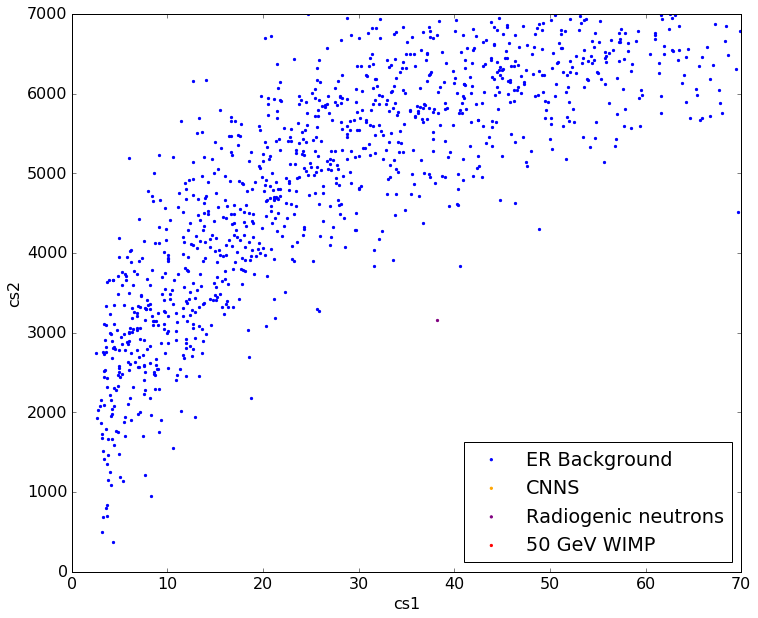

In [276]:
d = bg_dsets[0]
lf = lfs[50]
lf.base_model.show(d)
plt.legend(loc='lower right', scatterpoints=1)

Let's see what the likelihood function thinks of this:

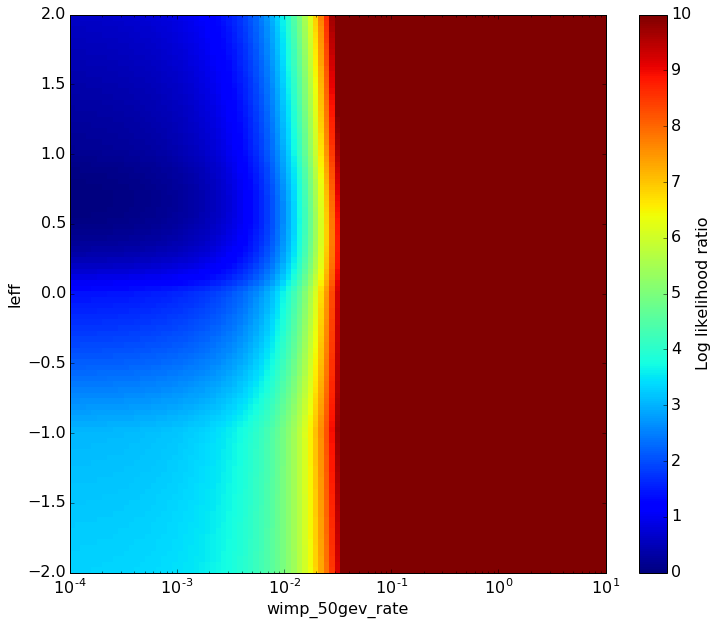

In [262]:
plot_likelihood_ratio(lf, ('wimp_50gev_rate', np.logspace(-4, 1, 100)), ('leff', np.linspace(-2, 2, 100)))
plt.xscale('log')

In [ ]:
As you can see the Leff

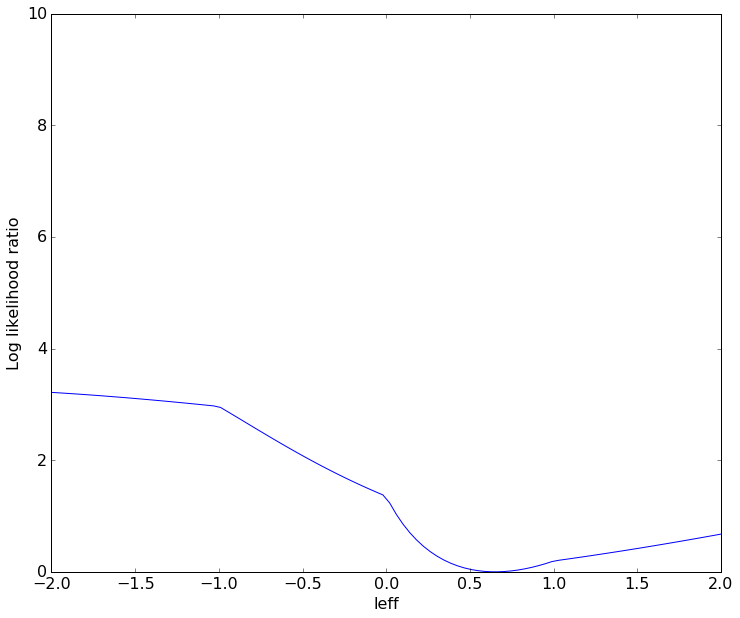

In [263]:
plot_likelihood_ratio(lf, ('leff', np.linspace(-2, 2, 100)), wimp_50gev_rate=1e-3)

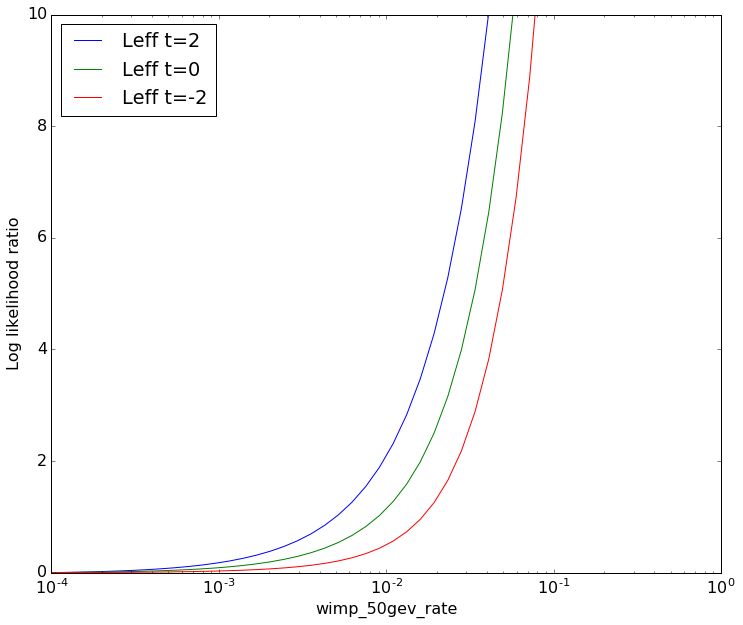

In [117]:
from wimpy.analysis import plot_likelihood_ratio

lf.set_data(d)
for leff in [2, 0, -2]:
    plot_likelihood_ratio(lf, ('wimp_50gev_rate', np.logspace(-4, 0, 50)), leff=leff, 
                          plot_kwargs=dict(label="Leff t=%s" % leff))
plt.legend(loc='upper left')
plt.xscale('log')

In [209]:
# %%timeit
# lfs[50](wimp_50_gev_rate=1, leff=0.1)
# 0.5 ms / likelihood function call
# Could probably do a small brute force search to seed the minimizer

In [200]:
bestfit(lf, guess=dict(wimp_50gev_rate=0))

({'leff': 0.6629220818160928, 'wimp_1000gev_rate': 0.0}, -6617.0380866164642)

In [201]:
bestfit(lf, guess=dict(wimp_50gev_rate=10))

({'leff': 0.6629220818160928, 'wimp_1000gev_rate': 0.0}, -6617.0380866164642)

In [124]:
limits_lr = {m: [] for m in wimp_masses}
limits_plr = {m: [] for m in wimp_masses}

for m in wimp_masses:
    lf = lfs[m]
    
    for i, d in enumerate(tqdm(bg_dsets)):
        lf.set_data(d)
        guess = {'wimp_%dgev_rate' % wimp_mass: 1e-2}
        limits_lr[m].append(wimplimit(lf, profile=False, leff=0, guess=guess))
        try:
            limits_plr[m].append(wimplimit(lf, profile=True, guess=guess))
        except Exception as e:
            print("Failure in limit setting for dataset %d, %d GeV: %s, %s" % (i, m, str(type(e)), str(e)))
        
    limits_lr[m] = np.array(limits_lr[m])
    limits_plr[m] = np.array(limits_plr[m])

  0%|          | 1/500 [00:00<01:22,  6.03it/s]/home/jelle/anaconda3/envs/pax/lib/python3.4/site-packages/scipy/optimize/_minimize.py:391: RuntimeWarning: Method Nelder-Mead cannot handle constraints nor bounds.
  RuntimeWarning)
 39%|███▉      | 196/500 [01:02<00:50,  6.03it/s]

Failure in limit setting for dataset 266, 10 GeV: <class 'ValueError'>, f(a) and f(b) must have different signs
Failure in limit setting for dataset 196, 50 GeV: <class 'ValueError'>, f(a) and f(b) must have different signs

 59%|█████▉    | 295/500 [01:26<00:43,  4.74it/s]


Failure in limit setting for dataset 295, 50 GeV: <class 'ValueError'>, f(a) and f(b) must have different signs

 69%|██████▉   | 345/500 [01:38<00:33,  4.62it/s]


Failure in limit setting for dataset 345, 50 GeV: <class 'ValueError'>, f(a) and f(b) must have different signs

 25%|██▍       | 124/500 [00:37<01:39,  3.78it/s]


Failure in limit setting for dataset 124, 100 GeV: <class 'ValueError'>, f(a) and f(b) must have different signs

 53%|█████▎    | 266/500 [01:14<00:47,  4.95it/s]


Failure in limit setting for dataset 266, 100 GeV: <class 'ValueError'>, f(a) and f(b) must have different signs

 59%|█████▉    | 295/500 [01:21<00:50,  4.09it/s]


Failure in limit setting for dataset 295, 100 GeV: <class 'ValueError'>, f(a) and f(b) must have different signs

 69%|██████▉   | 345/500 [01:34<00:38,  4.01it/s]


Failure in limit setting for dataset 345, 100 GeV: <class 'ValueError'>, f(a) and f(b) must have different signs

In [210]:
limits_lr_lowleff = {m: [] for m in wimp_masses}
for m in wimp_masses:
    lf = lfs[m]
    
    for i, d in enumerate(tqdm(bg_dsets)):
        lf.set_data(d)
        guess = {'wimp_%dgev_rate' % wimp_mass: 1e-2}
        limits_lr_lowleff[m].append(wimplimit(lf, profile=False, leff=-2, guess=guess))
        
    limits_lr_lowleff[m] = np.array(limits_lr_lowleff[m])

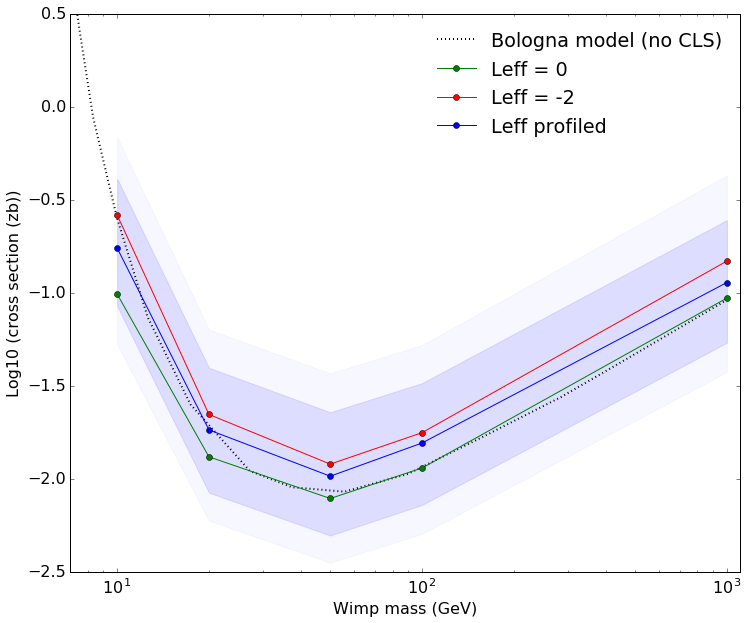

In [214]:
# Load the Bologna model data points
import pandas as pd
ms, xs = pd.read_csv('./bologna_nocls_limits/median_nocls.csv', skiprows=5, names=['m', 'xs'])[1:].values.astype(np.float).T
xs += 45
plt.plot(ms, xs, color='k', linestyle=':', label='Bologna model (no CLS)', linewidth=2)

for limit_dict, label, color in ((limits_lr, 'Leff = 0', 'g'),
                                 (limits_lr_lowleff, 'Leff = -2', 'r'),
                                 (limits_plr, 'Leff profiled', 'b')):
    limits_sigma = {sigma: np.array([np.percentile(limit_dict[m], 100*stats.norm.cdf(sigma)) 
                                     for m in wimp_masses])
                    for sigma in [-2, -1, 0, 1, 2]}
    plt.plot(wimp_masses, limits_sigma[0], 
             marker='o', color=color, label=label)
    if color == 'b':
        plt.fill_between(wimp_masses, limits_sigma[-1], limits_sigma[1], alpha=0.1, color=color)
        plt.fill_between(wimp_masses, limits_sigma[-2], limits_sigma[2], alpha=0.03, color=color)

plt.xscale('log')
plt.legend(loc='upper right', numpoints=1, frameon=False)
plt.xlim(7, 1100)
plt.ylim(-2.5, 0.5)
plt.xlabel("Wimp mass (GeV)")
plt.ylabel("Log10 (cross section (zb))")
plt.show()

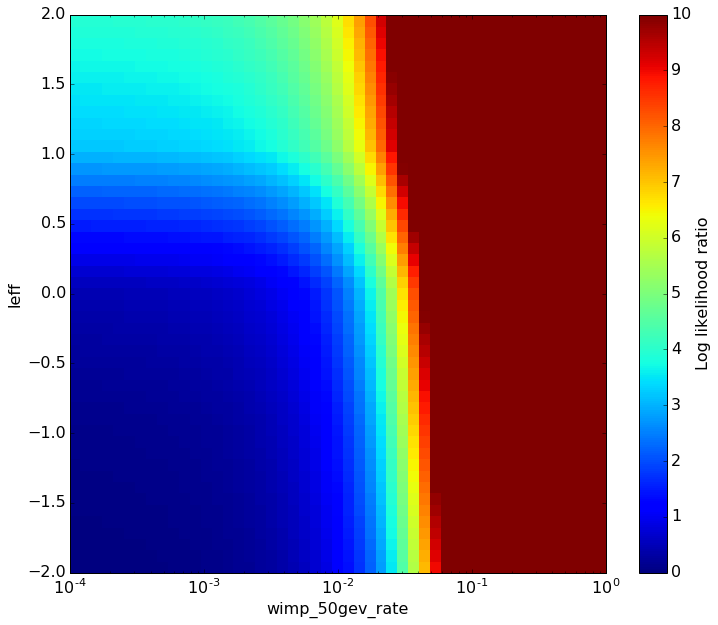

In [6]:
plot_likelihood_ratio(lf, ('wimp_50gev_rate', np.logspace(-4, 0, 50)), ('leff', np.linspace(-2, 2, 50)))
plt.xscale('log')

In [86]:
lfs[6].base_model.sources[-1].fraction_in_range

0.0013548333333333333

In [90]:
print([(s.name, s.fraction_in_range) for s in lfs[1000].base_model.sources])

[('er_bg', 0.50499842857142863), ('cnns', 0.00052899999999999996), ('radiogenics', 0.38290733333333332), ('wimp_1000gev', 0.73470183333333339)]


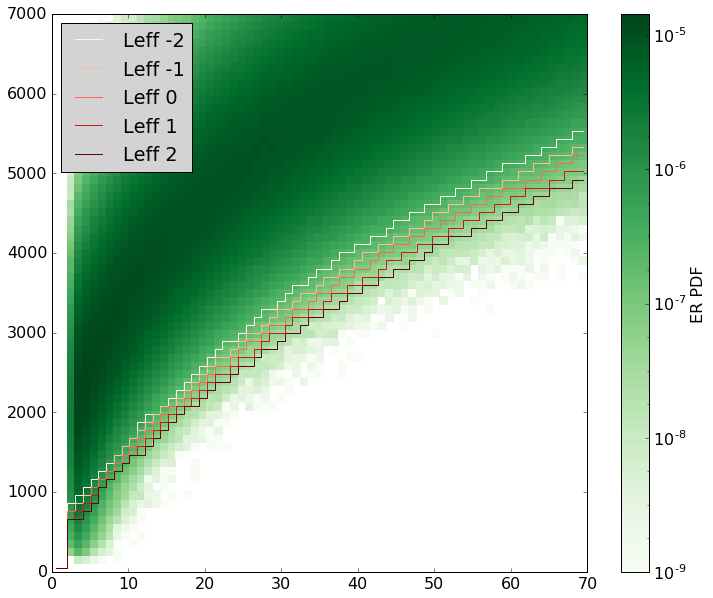

In [249]:
lf= lfs[1000]
for i, ((leff,), m) in enumerate(sorted(lf.anchor_models.items())):
    m.sources[-1].pdf_histogram.percentile(50, axis=1).plot(label='Leff %d' % leff, color=plt.cm.Reds(i/4))
   
m.sources[0].pdf_histogram.plot(cblabel='ER PDF', log_scale=True, vmin=1e-9, cmap=plt.cm.Greens)
#m.sources[0].pdf_histogram.percentile().plot(cblabel='ER PDF', log_scale=True, vmin=1e-8, cmap=plt.cm.Blues)
leg = plt.legend(loc='upper left')
leg.get_frame().set_facecolor('lightgray')

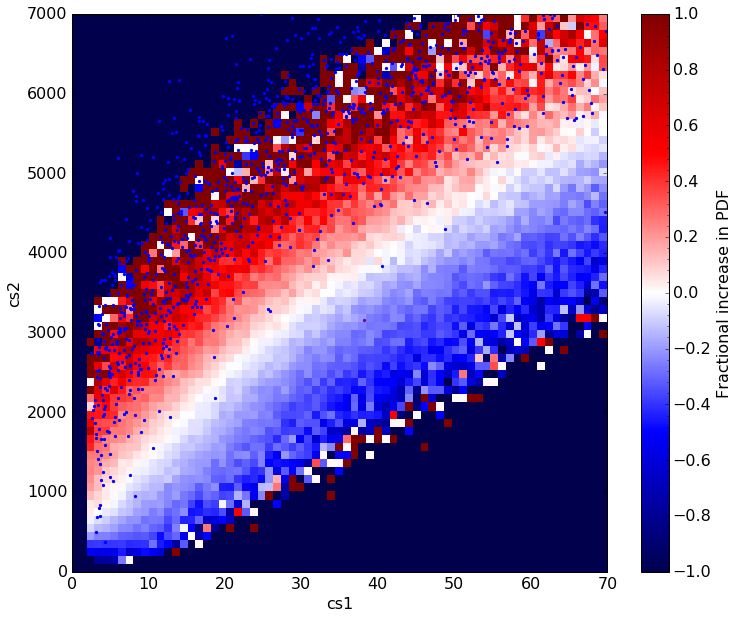

In [266]:
# Check if pdf differences are well sampled
lf= lfs[1000]
s_i = -1
a = lf.anchor_models[(0,)].sources[s_i]
b = lf.anchor_models[(-1.0,)].sources[s_i]
fr_increase = (b.pdf_histogram - a.pdf_histogram )/a.pdf_histogram
#q = max(abs(fr_increase.histogram.max()), abs(fr_increase.histogram.min()))
#q *= 0.5
q = 1
fr_increase.plot(vmin=-q, vmax=q, cmap=plt.cm.seismic, cblabel="Fractional increase in PDF")
lf.base_model.show(d)

# Test unprofiled

In [4]:
limits = []
for d in tqdm(bg_dsets):
    lf.set_data(d)
    limits.append(wimplimit(lf, profile=False, leff=0))

In [5]:
np.median(limits)

-2.0894897817476608

# Test profiled

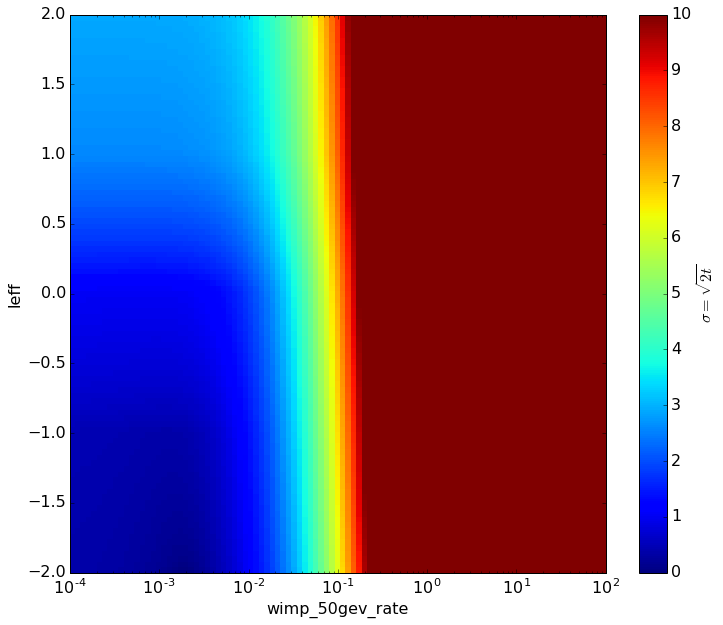

In [10]:
lf.set_data(bg_dsets[4])
twod_l_plot(lf, ('wimp_50gev_rate', 'leff'), 
            np.logspace(-4, 2, 100),
            np.linspace(-2, 2, 100), sigmamax=10)
plt.xscale('log')

In [15]:
plot_likelihood_ratio?

NameError: name 'tqdm' is not defined

In [14]:
limits = []
for d in tqdm(bg_dsets):
    lf.set_data(d)
    limits.append(wimplimit(lf, guess=dict(wimp_50gev_rate=1e-2)))

  0%|          | 2/1000 [00:00<02:57,  5.63it/s]/home/jelle/anaconda3/envs/pax/lib/python3.4/site-packages/scipy/optimize/_minimize.py:391: RuntimeWarning: Method Nelder-Mead cannot handle constraints nor bounds.
  RuntimeWarning)
  5%|▌         | 54/1000 [00:14<04:12,  3.75it/s]

KeyboardInterrupt: 

Leff moves the NR band horizontally; the lower LEff, the further left it goes. This has two effects: it pushes events below threshold (the rate effect) and pushes them nearer to the ER band (the shape effect). Both weaken your sensitivity; the first obivously so, the second because it makes ER leakage events more likely to be interpreted as WIMP events.

In [12]:
np.median(limits)

-1.9969817254743085

In [23]:
wimplimit(lf, guess=dict(wimp_50gev_rate=1e-2))

ValueError: f(a) and f(b) must have different signs

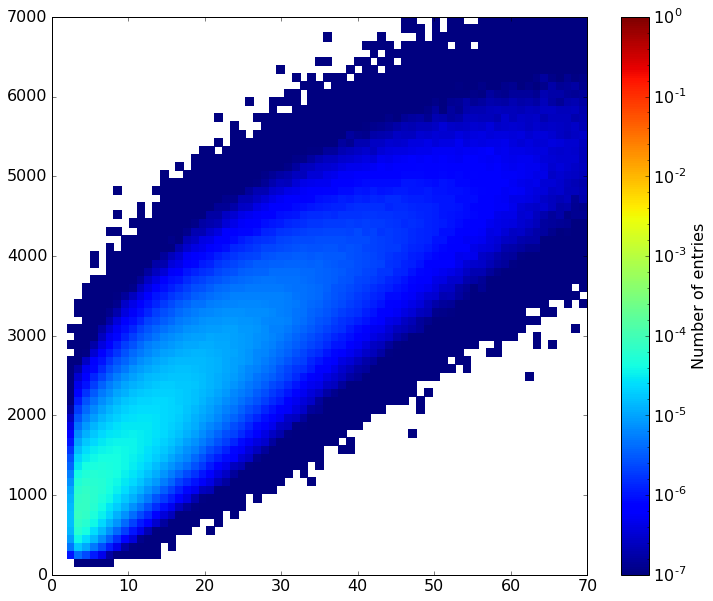

In [57]:
lf.anchor_models[(-2.0,)].sources[-1].pdf_histogram.plot(vmax=1, vmin=1e-7, log_scale=True)

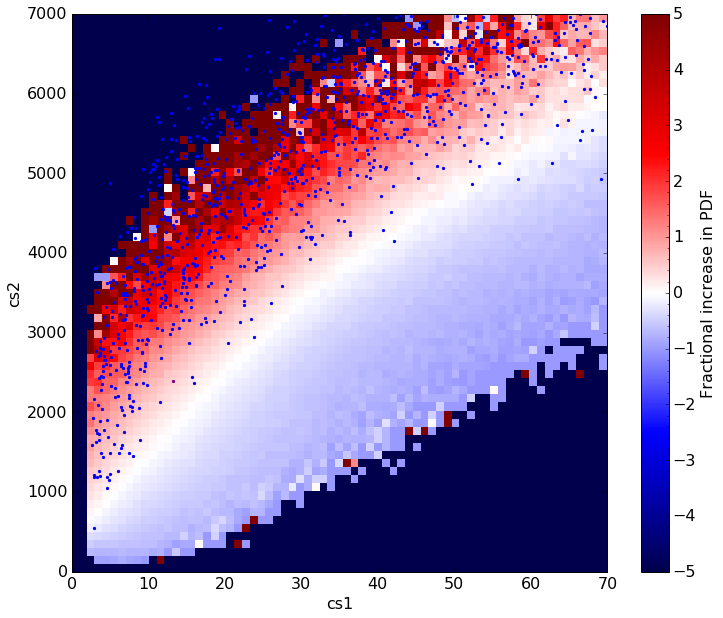

In [83]:
m = lf.base_model


array([[  7.49917537e-06,   3.46658265e-06,   5.43387976e-06, ...,
          9.48112645e-06,   7.60175324e-06,   1.20831242e-05],
       [  0.00000000e+00,   0.00000000e+00,   0.00000000e+00, ...,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00],
       [  0.00000000e+00,   8.16318890e-07,   6.68281786e-06, ...,
          4.22963156e-08,   2.53777893e-08,   4.65259471e-08],
       [  0.00000000e+00,   1.27025651e-07,   1.08195966e-05, ...,
          1.74348933e-08,   4.98139807e-09,   3.48697865e-08]])

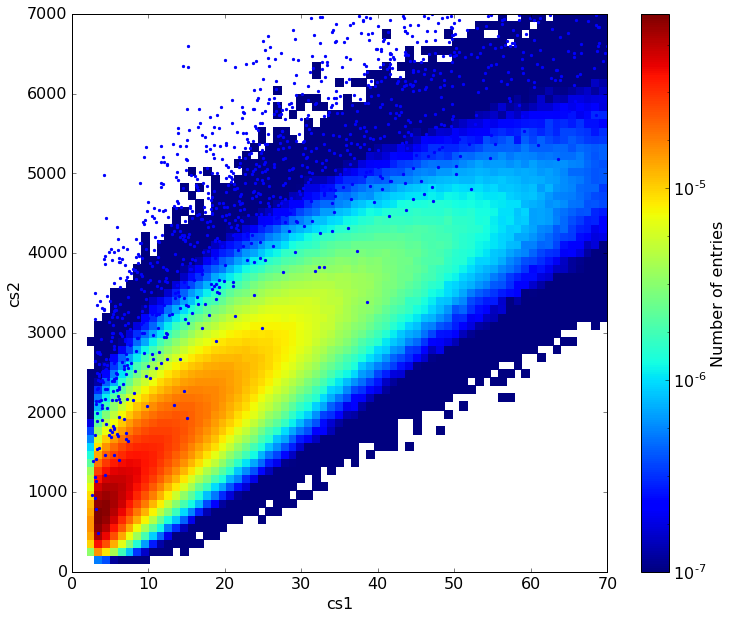

In [101]:
lf.base_model.sources[-1].pdf_histogram.plot(log_scale=True, vmin=1e-7)
lf.base_model.show(d)

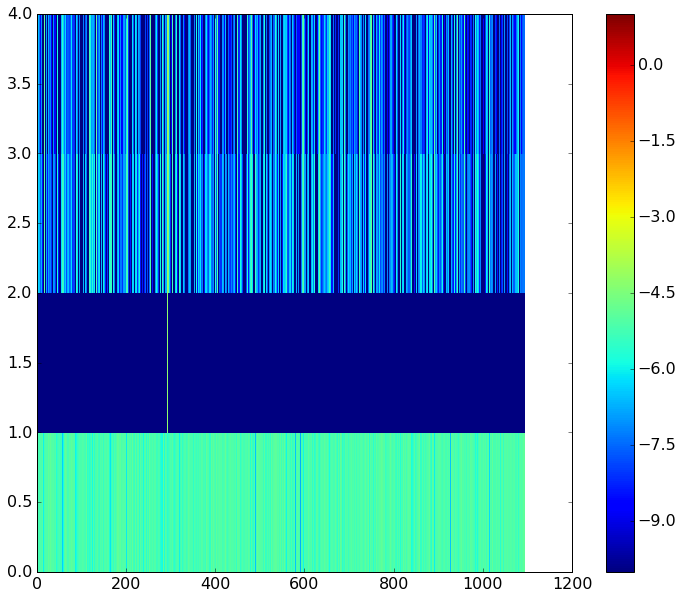

In [96]:
x = []
y = []
lps = np.log10(lf.base_model.score_events(d))
plt.pcolormesh(lps, vmin=-10, vmax=1)
# for (k,) model in lf.anchor_models.items():
#     x.append(k)
#     plt.pcolormesh(lps)
#     model.score_events(d)
#     #y.append(model.sources[-1].fraction_in_range)
plt.colorbar()
# plt.scatter(x, y)

In [71]:
for m in 
b.fraction_in_range

0.65017400000000003

In [70]:
a.fraction_in_range

0.60873983333333337

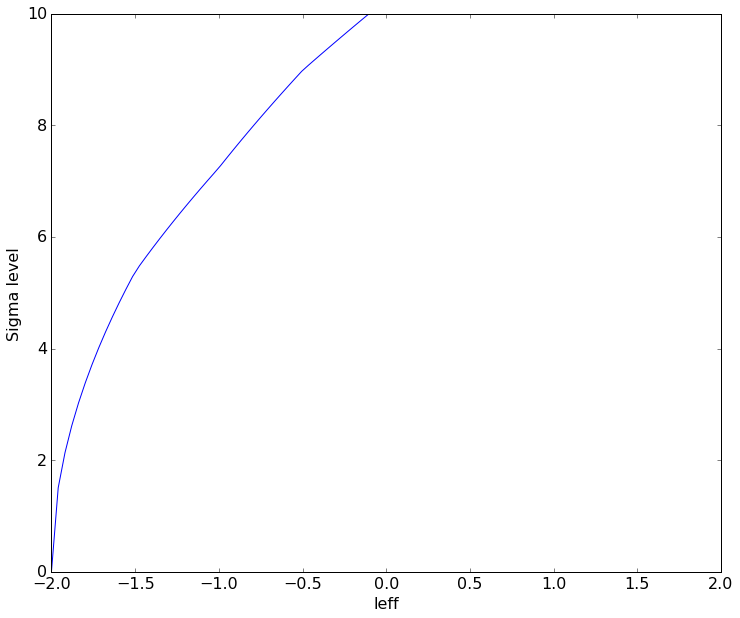

In [43]:
oned_l_plot(lf, 'leff', np.linspace(-2, 2, 100))

 10%|█         | 1/10 [00:02<00:24,  2.69s/it]/home/jelle/anaconda3/envs/pax/lib/python3.4/site-packages/scipy/optimize/_minimize.py:391: RuntimeWarning: Method Nelder-Mead cannot handle constraints nor bounds.
  RuntimeWarning)
                                               

In [ ]:
np.median(limits)

In [3]:
d = lf.base_model.simulate(rate_multipliers=dict(wimp_50gev=0))
lf.set_data(d)
lf.bestfit()

({'leff': -0.0054161672917497176, 'wimp_50gev_rate': 0.020822813562818676},
 -6155.7691027755609)

In [4]:
lf.set_data(lf.base_model.simulate(rate_multipliers=dict(wimp_50gev=0)))
wimplimit(lf)

-1.4893836085266434

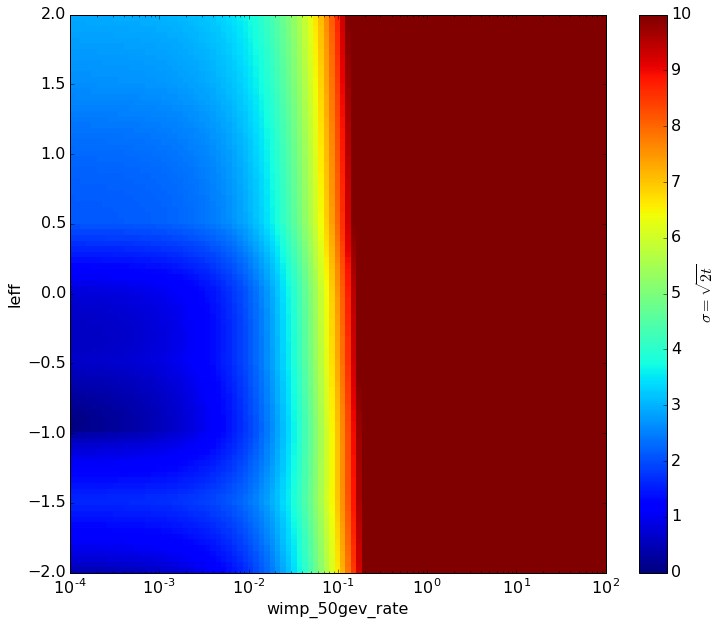

In [6]:
limits = []
for d in tqdm(bg_dsets):
    lf.set_data(d)
    limits.append(wimplimit(lf))

  2%|▏         | 23/1000 [00:03<02:47,  5.85it/s]/home/jelle/anaconda3/envs/pax/lib/python3.4/site-packages/scipy/optimize/_minimize.py:391: RuntimeWarning: Method Nelder-Mead cannot handle constraints nor bounds.
  RuntimeWarning)
 18%|█▊        | 182/1000 [00:29<02:47,  4.89it/s]

KeyboardInterrupt: 

In [10]:
np.median(limits)

-1.4559316933441981

In [ ]:

# target = 'wimp_50gev'
#     for s in lf.base_model.sources:
#         source_name = s.name
#         if source_name == target:
#             lf_kwargs[source_name + '_rate']= s.events_per_day * 10**wimp_strength
#         elif source_name.startswith('wimp'):
#             lf_kwargs[source_name + '_rate'] = 0

# Diagnostics

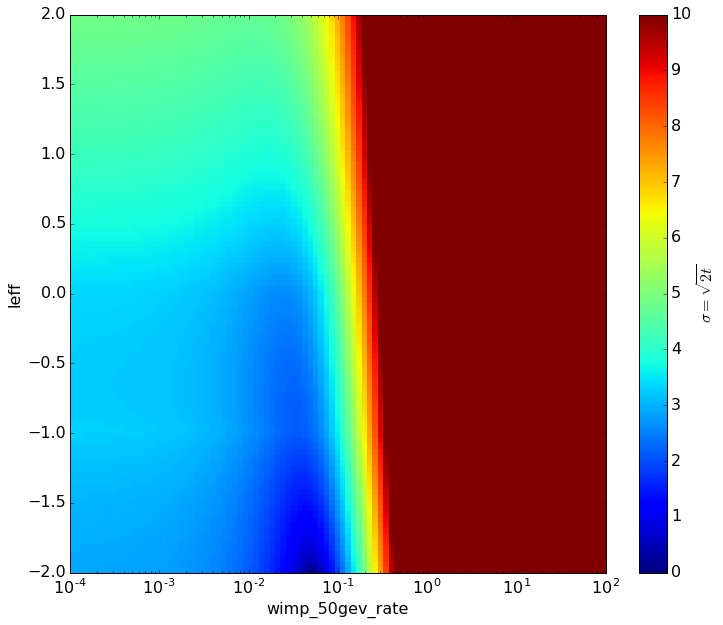

In [8]:
wimplimit(lf)

{'wimp_50gev_rate': 0.0039836040520757152, 'leff': -0.15014207644175226} -6612.78843155
-2.40866796159 2
{'wimp_50gev_rate': 0.0039836040520757152} {'leff': -0.15018750000000008} -6612.78843155 -6.96672941558e-10 1.64237441515
{'wimp_50gev_rate': 102.08081460211842} {'leff': -1.999999938964846} -45590.8046415 77956.0324199 1.64237441515


/home/jelle/anaconda3/envs/pax/lib/python3.4/site-packages/scipy/optimize/_minimize.py:391: RuntimeWarning: Method Nelder-Mead cannot handle constraints nor bounds.
  RuntimeWarning)


ValueError: f(a) and f(b) must have different signs

In [95]:
lf(wimp_50gev_rate=0, leff=0)

-9651.9764890156912

In [99]:
%%timeit
bestfit_scipy(lf, guess=dict(leff=1.99), minimize_kwargs=dict(method='Nelder-Mead'))

10 loops, best of 3: 66.5 ms per loop


In [100]:
%%timeit
bestfit_scipy(lf, guess=dict(leff=1.99))

10 loops, best of 3: 24.8 ms per loop


In [49]:
f([1])

-0.0

In [ ]:


        # if minimize_kwargs is None:
        #     # For some reason the default BGFS methods fail hard (probably because there are - inf regions
        #     # And Powell performs terribly (returns but often is far off from the minimum)
        #     minimize_kwargs = dict(method='Nelder-Mead', options=dict(maxiter=1e3))

        # optresult = minimize(objective, [x for _, x in unspecified], **minimize_kwargs)
        # if not optresult.success:
        #     raise RuntimeError("Optimization failure: ", optresult)
        # results = optresult.x if len(unspecified) != 1 else [optresult.x.item()]
        # return {unspecified[i][0]: results[i] for i in range(len(unspecified))}, -optresult.fun


In [83]:
example_dsets = [lf.base_model.simulate(rate_multipliers=dict(wimp_50gev=0)) for _ in tqdm(range(1000))]

In [88]:
list({1:2}.keys()) + list({2:3}.keys())

[1, 2]

In [84]:
limits = []
for d in tqdm(example_dsets):
    lf.set_data(d)
    limits.append(wimplimit())

  2%|▏         | 22/1000 [00:10<07:15,  2.25it/s]

RuntimeError: ('Optimization failure: ',      fun: inf
 success: False
       x: array([ 0.])
    nfev: 200
  status: 1
     nit: 67
 message: 'Maximum number of function evaluations has been exceeded.')

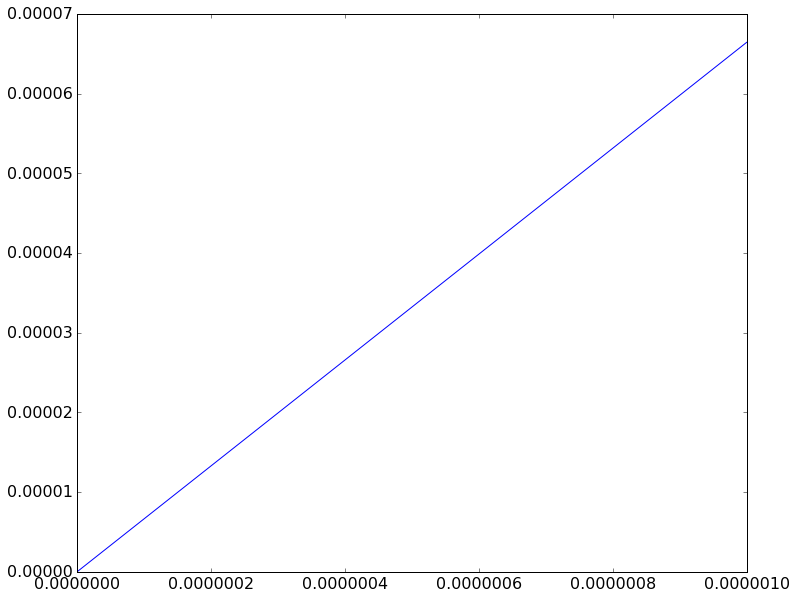

In [51]:
x = np.linspace(0, 1e-6, 100)
lhs = [lf(leff=0, wimp_50gev_rate=q) for q in x]
plt.plot(x, max(lhs) - lhs)
# plt.ylim(0, 10)

In [33]:
wimplimit()

ValueError: f(a) and f(b) must have different signs

In [14]:
lf.bestfit(wimp_50gev_rate=0)

({'leff': -0.5395625000000005}, -6194.6550354324563)

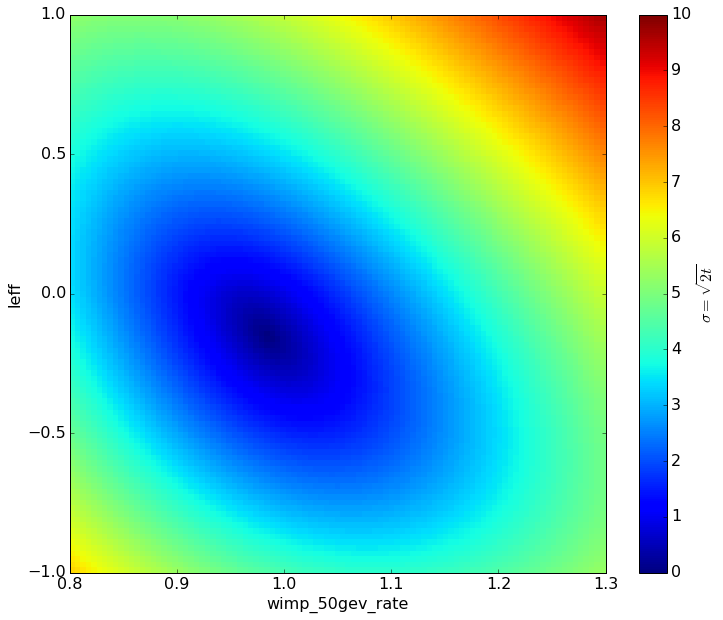

# Old stuff

In [150]:
no_wimp_strength = -10
max_wimp_strength = 2

def interval(confidence_level=0.9, kind='limit'):
    # Find the best-fit wimp strength
    optresult, max_likelihood = bestfit()
    best_strength = optresult[0] #if profile else optresult.item()

    def f(wimp_strength, z):
        fit, conditional_max_ll = bestfit(fix_strength=wimp_strength)
        return 2*(max_likelihood - conditional_max_ll) - z**2

    if kind == 'limit':
        return brentq(f,
                      best_strength, max_wimp_strength,
                      args=(stats.norm(0, 1).ppf(confidence_level),))

    elif kind == 'central':
        if best_strength <= m.no_wimp_strength:
            a = m.no_wimp_strength
        else:
            a = brentq(f,
                       no_wimp_strength, best_strength,
                       args=(stats.norm(0, 1).ppf(1/2 - confidence_level/2),))
        b = brentq(f,
                   best_strength, max_wimp_strength,
                   args=(stats.norm(0, 1).ppf(1/2 + confidence_level/2),))
        return a, b

    else:
        raise ValueError("Invalid interval kind %s" % kind)

In [152]:
# d = lf.base_model.simulate(rate_multipliers=dict(wimp_50gev=1))
example_dsets = [lf.base_model.simulate() for _ in tqdm(range(100))]

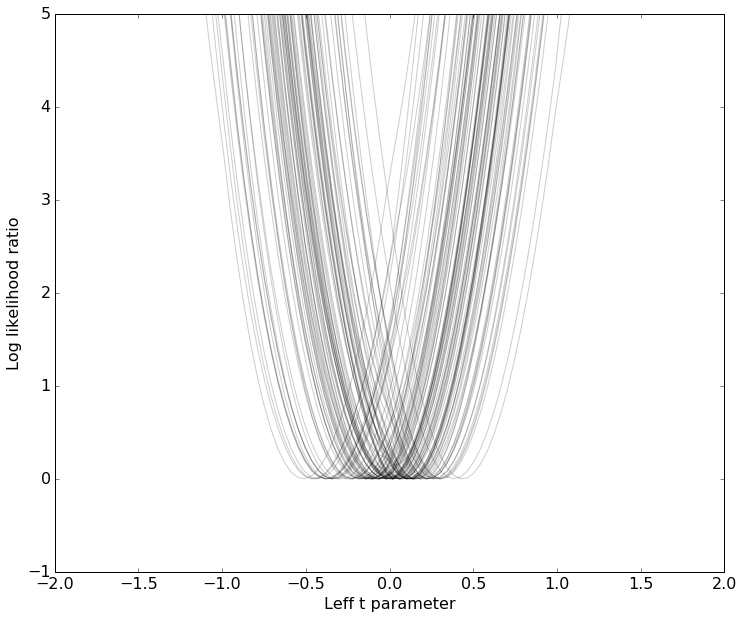

In [153]:
x = np.linspace(-2, 2, 100)

for d in tqdm(example_dsets):
    lf.set_data(d)
    lhs = np.array([loglikelihood(0, q) for q in x])
    plt.plot(x, lhs.max() - lhs, alpha=0.2, color='k')
plt.ylim(-1, 5)
plt.ylabel("Log likelihood ratio")
plt.xlabel("Leff t parameter")

In [154]:
bg_dsets = [lf.base_model.simulate(rate_multipliers={s: 0 for s in lf.source_list if s.startswith('wimp')}) 
            for _ in tqdm(range(100))]

In [156]:
lf.set_data(bg_dsets[0])



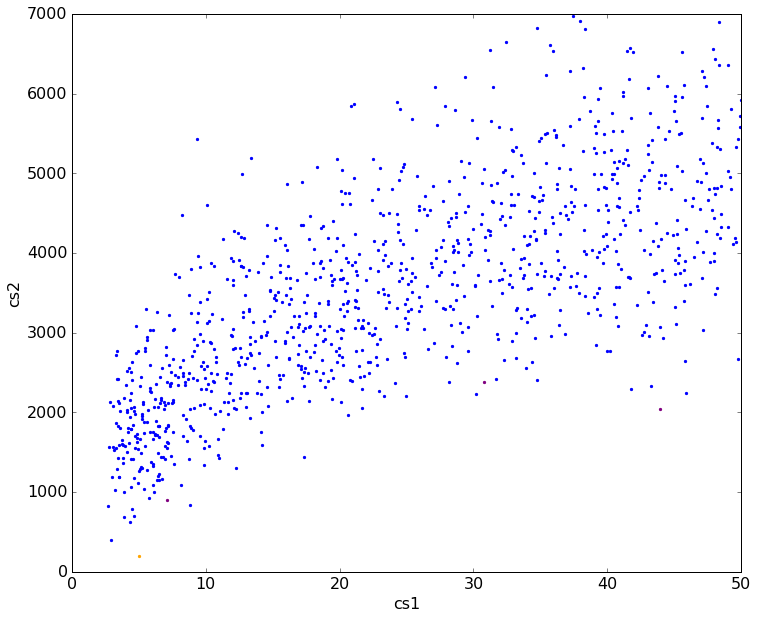

In [116]:
lf.base_model.show(bg_dsets[445])

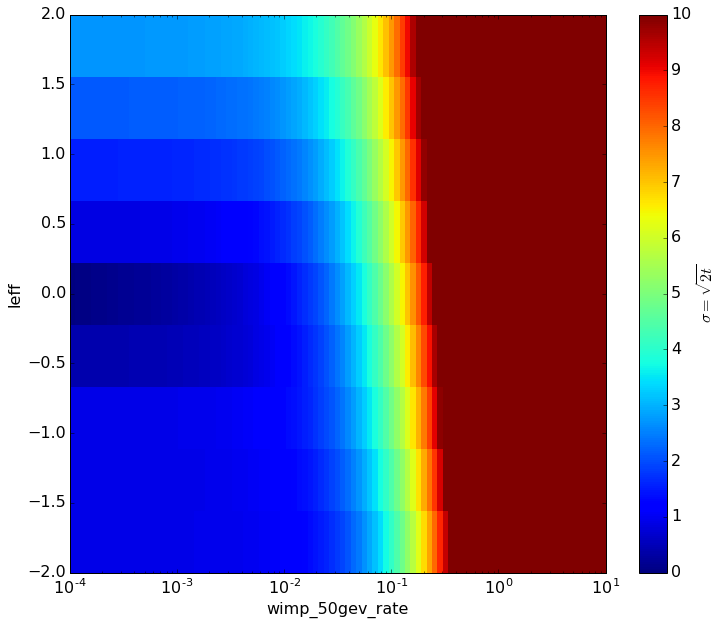

In [149]:
lf.set_data(bg_dsets[0])
twod_l_plot(lf, ('wimp_50gev_rate', 'leff'), np.logspace(-4, 1, 100), np.linspace(-2, 2, 10))
plt.xscale('log')

In [159]:
limits = []
for d in tqdm(bg_dsets):
    lf.set_data(d)
    limits.append(interval())

In [161]:
np.median(limits)

-1.9774824261506274

In [ ]:
np.std(limits)/np.sqrt(1000)

In [60]:
np.median(limits)

-1.5149854469913124

In [21]:
def wimp_interval(confidence_level=0.9, kind='limit', profile=False):
    """Return an interval of kind and confidence_level on dataset d
     - d is assumed to be restricted to the analysis range.
     - confidence level is the probability content of the interval (1 - the false positive rate)
     - kind can be 'central' (for a two-sided central CI) or 'limit' (for upper limits)
     - If profile=True, will compute a profile likelihood interval, i.e. will consider the rate uncertainty on each
       source.

    The interval is set using the likelihood ratio method, assuming the asymptotic distribution (Wilk's theorem)
    for the likelihood ratio test statistic.
    """
    ps = m.score_events(d)

    # Find the best-fit wimp strength
    optresult, max_likelihood = bestfit(m, d, ps=ps, fit_uncertainties=profile, fit_strength=True)
    best_strength = optresult[0] if profile else optresult.item()

    def f(wimp_strength, z):
        fit, conditional_max_ll = bestfit(m, d, wimp_strength, fit_strength=False, fit_uncertainties=profile)
        return 2*(max_likelihood - conditional_max_ll) - z**2

    if kind == 'limit':
        return brentq(f,
                      best_strength, m.max_wimp_strength,
                      args=(stats.norm(0, 1).ppf(confidence_level),))

    elif kind == 'central':
        if best_strength <= m.no_wimp_strength:
            a = m.no_wimp_strength
        else:
            a = brentq(f,
                       m.no_wimp_strength, best_strength,
                       args=(stats.norm(0, 1).ppf(1/2 - confidence_level/2),))
        b = brentq(f,
                   best_strength, m.max_wimp_strength,
                   args=(stats.norm(0, 1).ppf(1/2 + confidence_level/2),))
        return a, b

    else:
        raise ValueError("Invalid interval kind %s" % kind)

In [13]:
lf.base_model.get_source('wimp_50gev').events_per_day

1.0208081460211842

In [11]:
lf.set_data(d)
lf(wimp_50gev_rate=)

-6445.3927007290667

-6445.3927007290667

In [3]:
lf.add_rate_parameter('wimp_50gev')

In [4]:
lf()

OrderedDict([('wimp_50gev', None)])

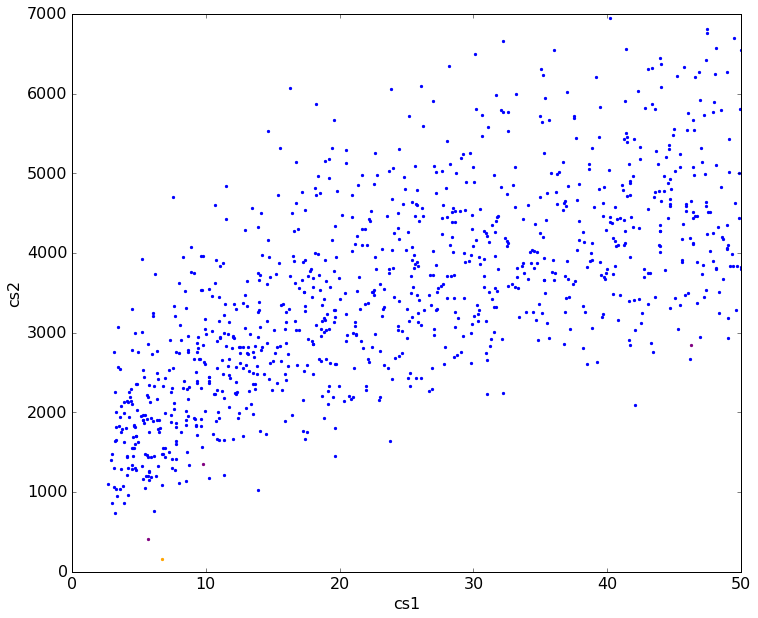

In [5]:

lf.base_model.show(d)
# plt.legend(loc='lower right')

In [ ]:
def bestfit(loglikelihood, guess_strength=0, fit_uncertainties=False, fit_strength=True, ps=None):
    """Returns best-fit wimp strength for dataset d, loglikelihood value at that point.
    Throws exception if optimization is unsuccesfull
    if float_uncertainties = True, fits and returns the rate uncertainties for each source
    ps = m.score_events(d), if you've already computed it.
    """
    # Determine what kind of minimization we should do.
    if fit_uncertainties and fit_strength:
        ll_kwargs = dict()   # TODO

        def objective(params):
            return -loglikelihood(**ll_kwargs)


    elif fit_uncertainties:
        guess = [0] * n_uncertain_sources

        def objective(params):
            return -loglikelihood(m, d, guess_strength, ps=ps,
                                  rate_modifiers=add_zeros_if_not_uncertain(params))

    elif fit_strength:
        guess = [guess_strength]

        def objective(wimp_strength):
            return -loglikelihood(m, d, wimp_strength, ps=ps)

    else:
        # Fit nothing: just calculate!
        return guess_strength, loglikelihood(m, d, guess_strength, ps=ps)

    # For some reason the default BGFS minimization fails hard... Powell does much better
    optresult = minimize(objective, guess, method='Powell')
    if not optresult.success:
        raise RuntimeError("Optimization failure: ", optresult)
    return optresult.x, -optresult.fun